##### Copyright 2019 The TensorFlow Authors.

# 세팅

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

 데이터셋 
 
 이 데이터세트에는 대기 온도/ 대기압 / 습도 등의 14가지 값이 들어있다

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

# 데이터 살펴보기

시간별 예측만을 다루므로 우리는 10분 간격에서 1시간으로 데이터를 서브샘플링하자.

In [3]:
df = pd.read_csv(csv_path)

In [4]:
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [5]:
date_time

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

In [6]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time. 

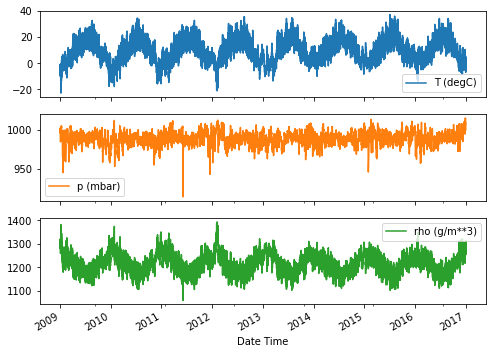

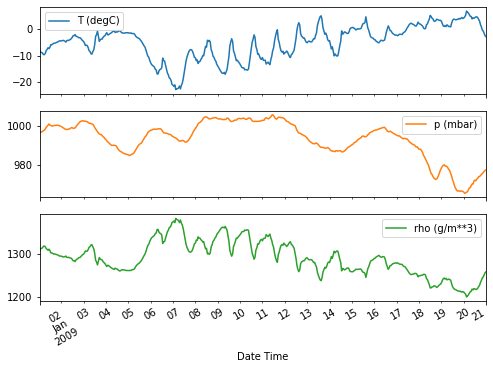

In [7]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

# 변수 정리

Next look at the statistics of the dataset:

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


## Wind velocity

헉 windy 열이 잘못된듯 하다. -9999 가 min 값이다. 풍속이 음수일 수 는 없으므로 0 으로 넣는것이 타당해보인다.

In [9]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

## Wind
마지막 열인 wd(deg) 는 0~360 도 정보이다. 그러나 0 도와 360도는 똑같지 않나? <br>
그리고 바람이 거의 없을떄에는 의미가 없다.

Text(0, 0.5, 'Wind Velocity [m/s]')

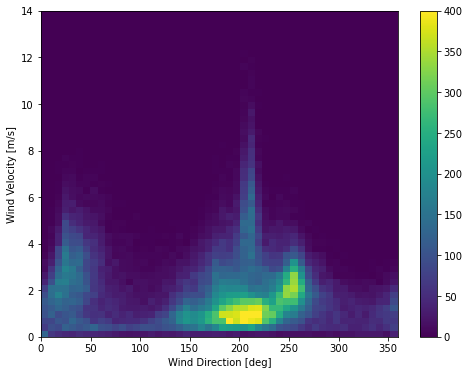

In [10]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

이경우에는 백터! 로 만드는게 훨씬 좋다

백터로 만들게 되면, 각도가 0~360 -> X증가량/ Y증가량 으로 CONTI 하고 해석이 바로 용이한 값으로 바뀌게 된다!

In [11]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad) # X 에 대한 방향
df['Wy'] = wv*np.sin(wd_rad) # Y 에 대한 방향

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

백터로 만들자~

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

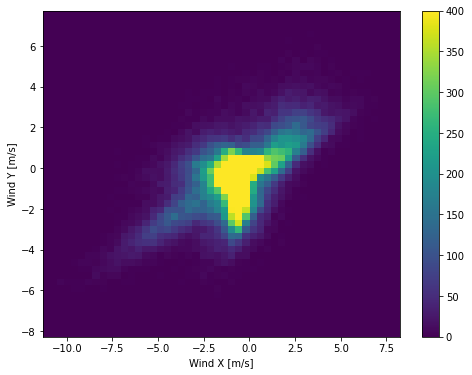

In [12]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

## Time

시간도 사실 매우 좋은 변수이다. 하지만 지금은 str 이므로 초로 변환하자.

In [13]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [16]:
timestamp_s

5         1.230739e+09
11        1.230743e+09
17        1.230746e+09
23        1.230750e+09
29        1.230754e+09
              ...     
420521    1.483179e+09
420527    1.483183e+09
420533    1.483186e+09
420539    1.483190e+09
420545    1.483193e+09
Name: Date Time, Length: 70091, dtype: float64

풍향과 유사하게 시간 (초)은 유용한 모델 입력이 아닙니다. 날씨 데이터이기 때문에 매일 및 매년주기가 명확합니다. 주기성을 처리 할 수있는 방법은 여러 가지가 있습니다.

사용 가능한 신호로 변환하는 간단한 방법은 sin 및 cos 를 사용하여 시간을 "시간"및 "시간 중"신호를 지우도록 변환하는 것입니다.

In [14]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

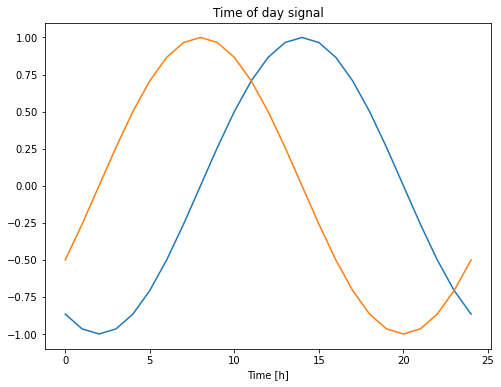

In [15]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. 

In this case we knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

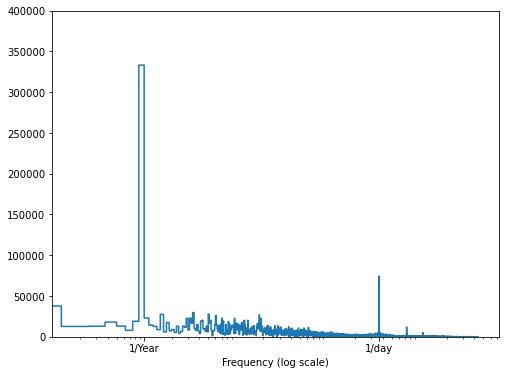

In [14]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

# 데이터 분할

We'll use a `(70%, 20%, 10%)` 으로 나뉜다.<br>
이떄 주의해야할것은 랜덤으로 섞인후에 잘리는게 아니라 시간순으로 잘리는것이다.<br>
이렇게 해야 시계열의 구조를 학습한 우리의 모델이 예측 및 테스트를 올바르게 하기 때문이다

In [15]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# 데이터 정규화
신경망 훈련에는 스케일링을 하는게 일반적인 방법이라고 한다. <br>
각 피쳐의 평균을 뺴고 표준편차로 나누자. <br>
이때 중요한것은 data leakage 현상을 막기위해 tarain 만을 사용해서 표준화시켜야 한다는 것이다<br> 
정규화는 이동평균을 이용해야한다고도 한다! 하지만 이거는 여기서 벗어난 주제이므로 정규화는 그냥 train 의 mean / std 로 표쥰화하자.


In [16]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

약간 꼬리가 길어보이지만 , 그래도 -9999 처럼 에러값은 없어보인다.

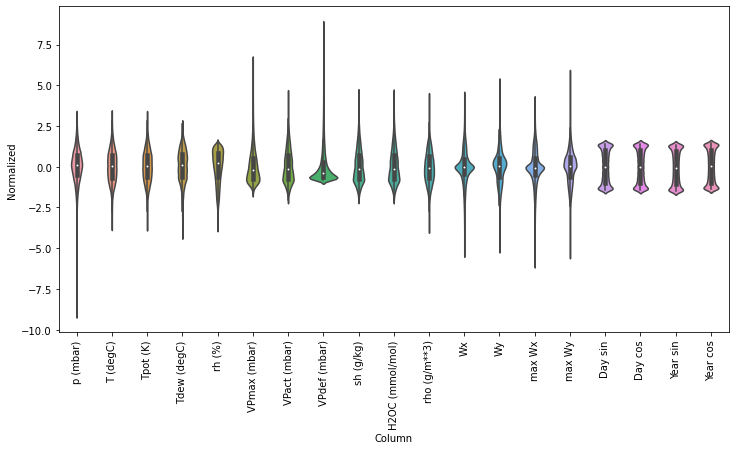

In [17]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# 데이터 윈도우
이 학습서의 모델은 데이터에서 연속 된 샘플 창을 기반으로 모델을 학습합니다.

입력 창(window)의 주요 기능은 아래와 같습니다.

- 입력 및 레이블 창의 너비 (시간 단계 수)
- 그들 사이의 시간 오프셋.
- 입력, 레이블 또는 둘 다로 사용되는 기능


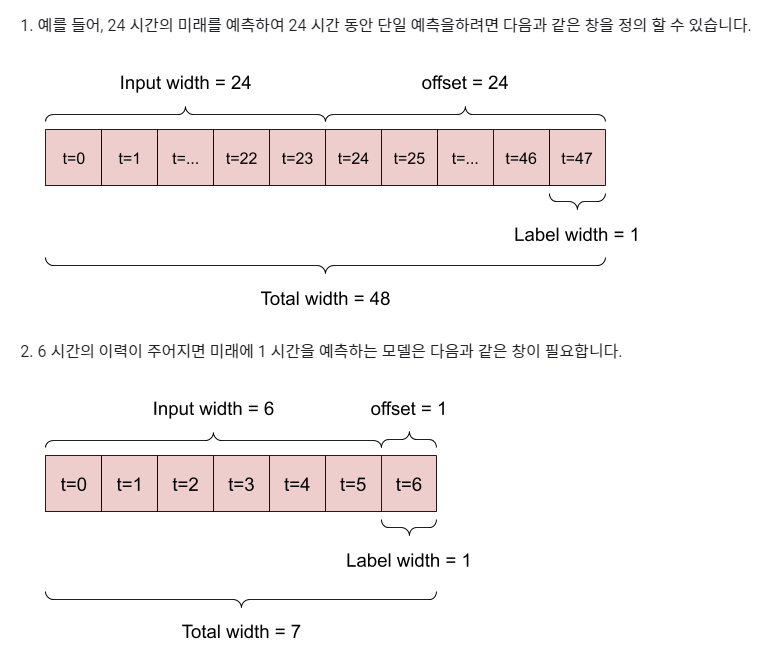

In [18]:
from IPython.display import Image
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries1.PNG') 

## Window Gnerator 정의

WindowGenerator 클래스를 작성하여 시작하자.<br>

이 class 는 tran / val / test 를 input 으로 받고 , 그 3개를 묶어서 나중에 사용할 수 있게 객체로 정의하게 됩니다.

__init__ 메소드에는 입력 및 레이블 index에 를 표출하고 train set 을 만드는 등 우리가 뒤에서 이용할 많은 것들을 atttibute 로 가지게 정의한다.

In [19]:
k = {name: i for i, name in enumerate(['A','B'])}

In [20]:
k

{'A': 0, 'B': 1}

In [21]:
# 입력 / 예측 등의 데이터에 대해 INDEX들을 가지는 값들을 가지는 메서드이다.
class WindowGenerator():
  def __init__(self,
               input_width, # 우리가 가지는 train data 의 width
               label_width, # 예측하고자 하는 기간의 width
               shift,       # train data 와 우리의 예측 기간(처음 시작점) 이 얼마나 떨어져있는지
               train_df=train_df,
               val_df=val_df,
               test_df=test_df,
               label_columns=None): # labelcolumns 는 우리가 예측하고자 하는 column들이다.
    # Store the raw data.
    # 위에서 설정했던 data set 에 대해서 slef atribute 가 되게 옮긴다.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # label col 의 columns 를 맞추어준다.
    self.label_columns = label_columns 

    # label_col 이 들어가게 된다면 ,그 col 에 대해서만 예측을 하게 된다! (univariate 한 예측)
    
    if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        # k = {name: i for i, name in enumerate(['A','B'])} 로 하면
        # k = {'A': 0, 'B': 1} 가 된다.
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}
    # train 의 column 을 위와같이 dic 형태로 저장한다.
    # 뒤에서 이 메서드를 이용해 그림을 그리게 될 거에요!

    # Work out the window parameters.
    self.input_width = input_width # 우리에게 주어지는 train data의 기간의 길이
    self.label_width = label_width # 우리가 predict 하고싶은 기간의 길이
    self.shift = shift # 우리가 predict 하게 될 때, 얼마나 train 의 마지막 기간과 떨어져있는지
    
    # 즉 일별데이터에서 train 은 1~15일 / 예측은 20일을 하고싶다면
    # input_width = 15
    # label_width = 1
    # shift = 5 

    self.total_window_size = input_width + shift
    # 총 total window 사이즈 결정 

    self.input_slice = slice(0, input_width) 
    # slice : 잘라내기 원하는 index 들을 정의하는 클래스
    # slice 객체를 형성한다.  [0 ~ indpu_width-1] 의 리스트를 형성한다고 생각하면 쉽다.
    # slice(0,k) 였다면 input_indices 는 [0,1,2,3....k-1]

    
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    # slice 의 값만큼 잘라내겠다는 의미이다.
    # 즉 input width의 길이만큼 input_indices 를 지정해주겠다는 이야기
    
    # 즉 일별데이터에서 train 은 1~15일 / 예측은 20일을 하고싶다면
    # input_width = 15
    # input_indices = [0,1,2,.... 14]

    self.label_start = self.total_window_size - self.label_width
    # 예측하기 시작하는(즉 label_start) 지점에 대한 인덱스를 형성하고 싶다!
    # 시작하는 값은 총 window size - 예측하고자 하는 길이
    
    self.labels_slice = slice(self.label_start, None)
    # None 으로 slicing 할 경우 앞의 값까지를 없애고 slicing 하게 된다.
    # 즉 
    # kkk = 3
    # np.arange(7)[slice(kkk,None)]
    # -> array([3, 4, 5, 6])
    
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    # 드디어 label_indies / 즉 예측에 사용되게 되는 인덱스들을 얻었다.
    # 즉 일별데이터에서 train 은 1~15일 / 예측은 20일을 하고싶다면
    # label_indices = [19] 가 나온다. (1일 예측이므로)

    # 얘는 자기가 어떤 상태를 가지고있는지 설명하는 함수
  def __repr__(self): 
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

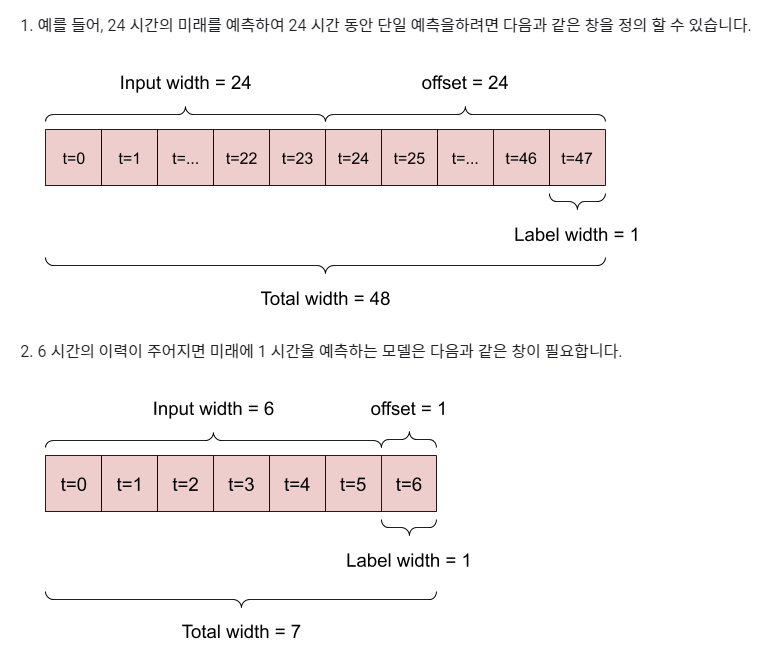

In [22]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries1.PNG') 

In [23]:
w1 = WindowGenerator(input_width=24, # train 은 24개! 
                     label_width=1, # 예측하고자 하는 기간은 1
                     shift=24, # 이떄에 inputwidth 와 label 은 24의 기간만큼 떨어져있다.
                     label_columns=['T (degC)']) # 예측하고자 하는것은 T(degC)
w1
# OUTPUT 되는 값을 보면, 총 Window 의 size 는 48 임을 볼 수 있다.

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [24]:
w2 = WindowGenerator(input_width=6, # train 은 6개!
                     label_width=1, # 예측하고자 하는 기간은 1
                     shift=1,  # 이떄에 input width 와 label 은 24의 기간만큼 떨어져있다.
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

## split_window 메소드 추가
연속적인 입력 목록이 주어지면 split_window 메소드는 input 창과 lable 창으로 변환합니다.

위의 예제 w2 는 다음과 같이 분할됩니다.

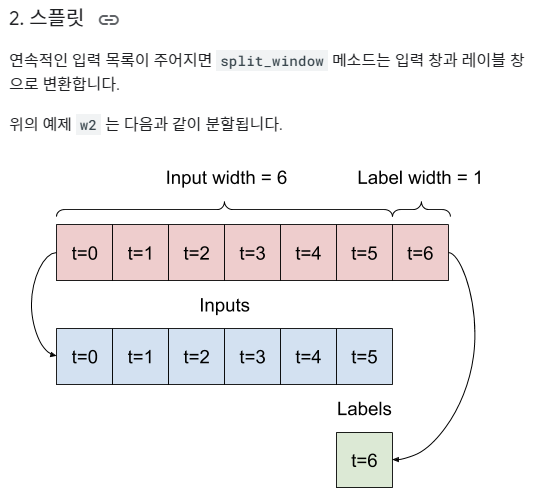

In [25]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries2.PNG') 

In [26]:
# 지금 작업은 Window Generator 에 split window 를 추가하는 작업이다.
# 아직 features 를 정의하지 않아서 이게뭐지? 

def split_window(self, features):
    # 메서드가 feature 가 추가되었다. 여기에는 batch 가 추가된 window 들이 들어간다.
    # 즉 (batch, time, features) 의 shape 를 가지는 데이터가 들어간다.
    inputs = features[:, self.input_slice, :]
    # (batch, time, features) 순서이다.
    # time의 순서를 정해서 slicing 해야한다.
    # slicing 을 어떻게 할지 ( 그니까 어디까지를 예측구간. train 구간으로 할지) 는 우리가 이미 앞에서 정하였따.
    # 그 input.alice 를 토대로 형성되어있는 window 들을 잘라주는 작업이다.
    labels = features[:, self.labels_slice, :]
    # 이는 예측되는 데이터들
    if self.label_columns is not None: # 즉 예측되는 label의 col이 정해져있다면!
        labels = tf.stack( 
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1) # feature 들을 이 함수식을 통해서 제한하자!

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
    # 이제 우리가 정한 label / train 의 크기만큼 window 의 집합이 분할되었다!    

# 이제 Windowgeneratot class 에 메서드를 추가하자!
WindowGenerator.split_window = split_window 

Try it out:

In [27]:
tf.stack([np.array([1,2,3]),
         np.array([4,5,6])])

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]])>

w2 = WindowGenerator
(input_width=6, # train 은 6개!  <br>
label_width=1, # 예측하고자 하는 기간은 1 <br>
shift=1,  # 이떄에 input width 와 label 은 24의 기간만큼 떨어져있다. <br>
label_columns=['T (degC)'])<br>
로 정의했음을 기억하자

In [105]:
# Stack three slices, the length of the total window:
# 윈도우가 아래와 같이 생성되었다고 가정하자.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])
# tf.stack 으로 행렬들을 합친다.
# 첫번쨰 차원에 계속 적재된다. 
# 즉 w2.total_window_size 의 사이즈를 가지는 3개의 데이터셋들을 묶는다.
# 이 경우는 batch 가 3개이다.
example_inputs, example_labels = w2.split_window(example_window)
# 이제 w2 를 우리가 정한 label/train 의 사이즈만큼 만큼 스플릿 하겠다는 의미이다.

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
# 처음에 정의한 window 의 exampel 의 사이즈
# 맨 앞은 batch size 이다.
print(f'Inputs shape: {example_inputs.shape}')
# 이를 split windows 에 넣어서 변한시켰을 때의 shape
# batch size 는 그대로인것을 볼 수 있다.
print(f'labels shape: {example_labels.shape}')
# tran_label 을 넣었을 떄에 변환된 모습

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


In [106]:
len(example_labels)

3

- 가장 안쪽 ( 여기 , , ) 의 인덱스는 배치사이즈가 된다.
- 가운데 인덱스는  시간/공간이 됩니다.(즉 우리가 정한 window 의 사이즈) 
- 가장 바깥쪽(, , 여기) 는 X 의 feature 수가 된다.

- 위 코드는 원래 window 를 2개의 7시간 간격 창으로 구성되었습니다.
- 그리고 각 window 는 6 timestep 19 feature / 1 timestep 1 feature 로 나누었습니다.
- 지금 label 의 feature 은 하나인데 그 이유는 windowgenerator 가 initialized with `label_columns=['T (degC)']` 이기 떄문입니다.
- 지금 우리는 predict single output label 이므로 이렇게 feature 가 하나만 나오게 됩니다.

## Plot 메소드 추가

이 그림은 항목이 참조하는 시간을 기준으로 입력, 레이블 및 (나중에) 예측을 정렬합니다.

In [29]:
# example 메서드를 저희가 추가해요!
# 이 example 은 모델의 결과를 visualizing 할 떄에 큰 도움이 된다.
# 따로 메서드 안에 이 example 을 형성하는 부분은 없으므로 위 과정을 밟도록 하자!
w2.example = example_inputs, example_labels 

In [72]:
# 이 def 는 example 에 대해서 우리의 예측값이 과연 어떻게 행동하는가 를 보여주는 것이다.
# 그러므로 선행되어야하는 것은 .example 을 우리가 위처럼 선언해주어야하는것 
# 그리고 model 을 만들어야 하는 것 두가지 이다.
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    # 어떤 model 로 예측했는지!
    # 어떤것을 예측했는지! (즉 이때에 보는건 한 변수에 대한예측치입니다~)
    # max_subplot : 몇개의 plot 을 볼까요?
  inputs, labels = self.example
# 앞에서 example 은 우리가 정의하는 부분이였습니다! 우리가 정의한 input / label 을 풀어봐요
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
# 저희가 그릴 col 의 index 를 반환합니다! 
# 예를 들어서 col 이 ['키','몸무게','재력'] 인 경우 키는 0 입니다.
  max_n = min(max_subplots, len(inputs))
# max_n 은 min(3, 배치 크기!)
  for n in range(max_n): 
        # 3개 그린다고 보면 됩니다.
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    # n 번쨰 배치에 대해서
    # 우리가 정한 feature 로 y 를 그리는데, 
    # x 의 기준은 가운데 값으로...! 가운데는 input_indices 에서 정한 값으로 그리게 됩니다.
    # 그러므로 x 축의 값은 총 6개가 됩니다.

    if self.label_columns: # 즉 self.label_columns 가 비어있지 않다면
      label_col_index = self.label_columns_indices.get(plot_col, None)
      # 저희가 그릴 label 의 index 는 지정해준 값입니다.
    else: # 비어있다면?
      label_col_index = plot_col_index
      # 저희가 나타내고 싶었던(즉 예측하고자 했던) 것으로 자동설정합니다.
    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None: # 모델에 대한 예측을 형성한다
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot
# 즉 이 경우는 , 우리가 위  example_inputs, example_labels 에서 어떻게 times 를 정해주었냐에 따라서 
# 모델들이 예측하는 범위가 달라지게 됩니다!
# 만약 우리 예측이 엄청 멀게 된다면,,, 그건 시각화 하기 힘들겟죠?

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

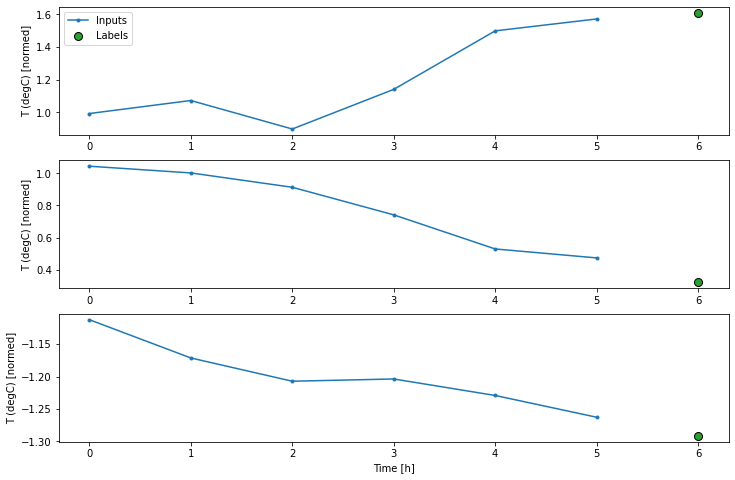

In [73]:
# 아무것도 없으면 그냥 label 을 그립니다. 
# 모델에 대한 예측치 없음
# 즉 의미가없어요~ 모델 형성한 다음에 쓰십셔
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

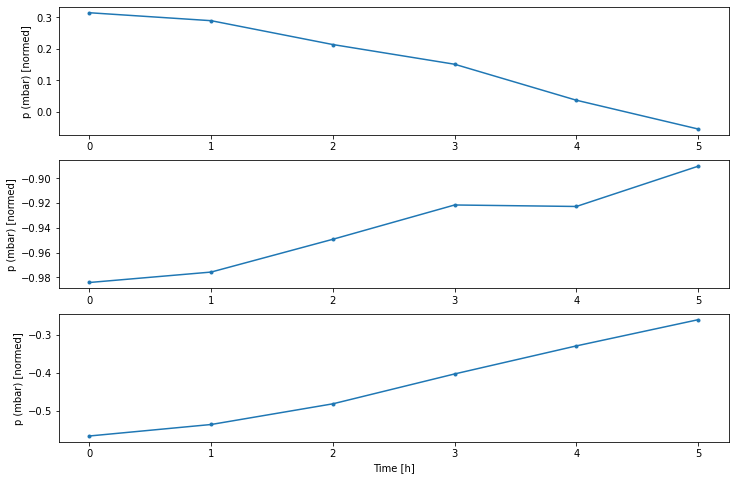

In [74]:
w2.plot(plot_col='p (mbar)')

##  make_dataset 메소드 추가

마지막으로이 make_dataset 메소드는 시계열 DataFrame 을 가져 tf.data.Dataset preprocessing.timeseries_dataset_from_array 함수를 사용하여 (input_window, label_window) 쌍의 tf.data.Dataset 으로 변환합니다.

In [33]:
# 시계열 데이터 프레임을 
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32) 
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data, # 위에서 정한 data
      targets=None, # target 이 되는 data 가 들어간다.
      sequence_length = self.total_window_size,
      # output sequence 의 길이.
      # total_windowz_size 를 넣어서 예측까지 포함하도록 한다.
      sequence_stride = 1, 
      # 데이터의 stride 는 1로 하고싶다. (거의다 1일듯?)
      shuffle=True,
      # output sample 을 섞을지 말지.
      batch_size=32,
      # batch_size 는 데이터를 묶어준다. 
      # 한번에 하나씩 학습하면 너무 오개래 걸리니까.. !
    )

    ds = ds.map(self.split_window) 
    # split window 해서 나온 input / label 데이터에 대해서 위 설정대로 묶어주겠다는 의미이다.
    # map : Dataset 전체에함수를 맵핑.
    # split_window 메서드를 적용시켜서

    return ds

WindowGenerator.make_dataset = make_dataset

Consider indices [0, 1, ... 99]. With sequence_length=10, sampling_rate=2, sequence_stride=3, shuffle=False, the dataset will yield batches of sequences composed of the following indices:

First sequence:  [0  2  4  6  8 10 12 14 16 18]<br>
Second sequence: [3  5  7  9 11 13 15 17 19 21]<br>
Third sequence:  [6  8 10 12 14 16 18 20 22 24]<br>
...<br>
Last sequence:   [78 80 82 84 86 88 90 92 94 96]<br>

- data: Numpy array or eager tensor containing consecutive data points (timesteps). Axis 0 is expected to be the time dimension.
- targets: Targets corresponding to timesteps in data. It should have same length as data. targets[i] should be the target corresponding to the window that starts at index i (see example 2 below). Pass None if you don't have target data (in this case the dataset will only yield the input data).
- sequence_length: Length of the output sequences (in number of timesteps).
- sequence_stride: Period between successive output sequences. For stride s, output samples would start at index data[i], data[i + s], data[i + 2 * s], etc.
- sampling_rate: Period between successive individual timesteps within sequences. For rate r, timesteps data[i], data[i + r], ... data[i + sequence_length] are used for create a sample sequence.
- batch_size: Number of timeseries samples in each batch (except maybe the last one).
- shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
- seed: Optional int; random seed for shuffling.
- start_index: Optional int; data points earlier (exclusive) than start_index will not be used in the output sequences. This is useful to reserve part of the data for test or validation.
- end_index: Optional int; data points later (exclusive) than end_index will not be used in the output sequences. This is useful to reserve part of the data for test or validation.


## 함수 적용

WindowGenerator 객체는 교육, 검증 및 테스트 데이터를 가지게 되었다.. <br>
위의 make_dataset 메소드를 사용해서 tf.data.Datasets 형태로 만들어서, tf 에서 이용할 수 있게 하기 위한 특성을 추가하자. <br>
또한 쉽게 액세스하고 플로팅하기위한 example 도 추가하였다. <br>



In [34]:
# instance 속성으로 접근해서 method 를 추가합니다.
# ptrain(self) 라는 메서드를 class 인 windowgenerator 에 추가!
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

# 이건 그냥.. 예시 데이터셋도 한번 처리해보라는것
@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

# 메서드 추가
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

이제 WindowGenerator 목적은 당신이에 액세스 할 수 있습니다 tf.data.Dataset 당신이 할 수있는 그렇게 쉽게 반복 처리 데이터를 통해, 객체.

Dataset.element_spec 속성은 데이터 세트 요소의 구조, dtypes 및 모양을 알려줍니다.



In [35]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Dataset 반복하면 구체적인 배치가 생성됩니다.

현재 w2.train 은 
All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)

w2.train 은 make_dataset(self.train_df) 으로 dataset 을 묶은 상태! 

즉 batch size 가 32가 되게 이미 묶은 상태이다.

In [36]:
for example_inputs, example_labels in w2.train.take(1):
    # 그냥 example 하나 뽑아본거에요~
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


# Single step models

이러한 종류의 데이터를 기반으로 구축 할 수있는 가장 간단한 모델은 현재 조건 만 기반으로 미래에 단일 기능의 값을 1 시간 간격 (1h)으로 예측하는 모델입니다.

따라서 미래의 T (degC) 값을 1h로 예측하는 모델을 구축하는 것으로 시작해 보자!

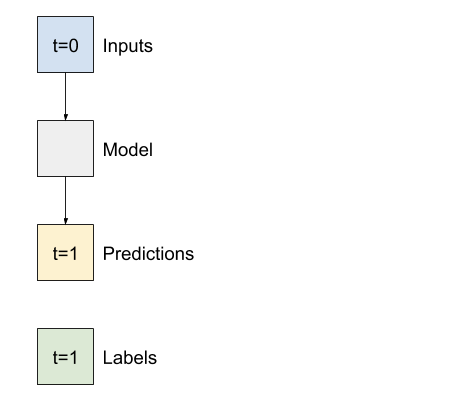

In [37]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries3.PNG') 

In [38]:
single_step_window = WindowGenerator(
    input_width=1, # 우선 input_width 는 우리에게 주어진 train set 의 길이이다.
    label_width=1, # label wifth 는 우리가 예측하고자 하는 길이이다.
    shift=1, # 우리가 예측하는 날짜는 train 의 마지막과 얼마나 떨어쟈있는지
    label_columns=['T (degC)']) # 어떤 label 을 뽑아낼지!
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

한번 train 으로 어떤 값이 변환되었는지 살펴보자~


In [39]:
for example_inputs, example_labels in single_step_window.train.take(1):  
    # take = 첫번쨰 값을 보는거. 한번 볼게요~
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline
모델의 성능을 검증하기 위해 제일 간단한 모델을 한번 형성해보는것도 좋습니다.

즉 그냥 1시간 전의 온도를 다음 온도로 예측하겠다는 것 입니다. 

온도가 천천히 변하기 떄문에 어느정도는 합리적으로 보이지 않나요?

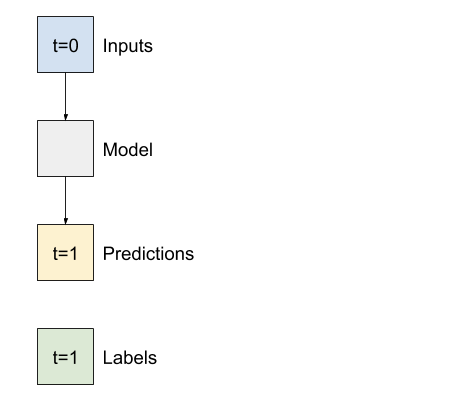

In [40]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries3.PNG') 

In [41]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index # 어떤 인덱스 예측을 할 것인지!

  def call(self, inputs):
    if self.label_index is None:
      return inputs # none 이면 그냥 input으로..
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

사실 모델이 HIDDEN NODE 도 없고... 그냥.. 별 의미가 없는것 같다.

In [42]:
baseline = Baseline(label_index=column_indices['T (degC)']) 
# 나는 예측할 index 로 T(degC) 를 선택할게요!

baseline.compile(loss=tf.losses.MeanSquaredError(), # loss 는 mse 로 
                 metrics=[tf.metrics.MeanAbsoluteError()])  #metric 는 mae 로

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val) 
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 0s 841us/step - loss: 0.0128 - mean_absolute_error: 0.0785


그것은 몇 가지 성능 메트릭을 인쇄했지만 모델이 얼마나 잘 수행되고 있는지에 대한 느낌을주지 않습니다.

WindowGenerator 에는 plot 메소드가 있지만 단일 샘플만으로도 plot은 흥미롭지 않습니다. 따라서 한 번에 24 시간 연속 입력 및 레이블 창을 생성하는 더 넓은 WindowGenerator 를 만듭니다.

wide_window 는 모델 작동 방식을 변경하지 않습니다. 이 모델은 여전히 ​​단일 입력 시간 단계를 기반으로 예측 1h를 미래로 만듭니다. 여기서 time 축은 batch 축과 같은 역할을합니다. 각 예측은 시간 단계 사이의 상호 작용없이 독립적으로 이루어집니다.



- input_width : 주어지는 데이터의 길이
- label indices : 예측하게 되는 label 
- label_columns : 예측하게 되는 featrue 

In [75]:
wide_window = WindowGenerator( 
    input_width=24, # 주어지게 되는 train 의 길이! 
    label_width=24, # 예측해야하는 test 의 길이! 
    shift=1, # train 과 예측은 얼마나 떨어져있을까요? <br>
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

이 확장 된 창은 코드 변경없이 동일한 baseline 모델로 직접 전달 될 수 있습니다. 입력과 레이블의 타임 스텝 수가 같고 기준선이 입력을 출력으로 전달하기 때문에 가능합니다.

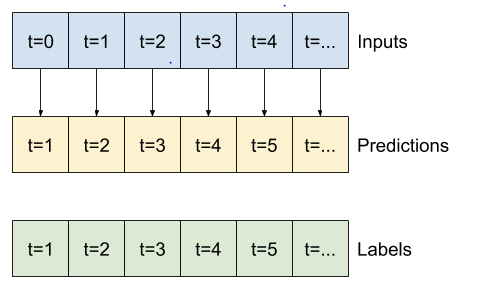

In [76]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries5.PNG') 

In [77]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

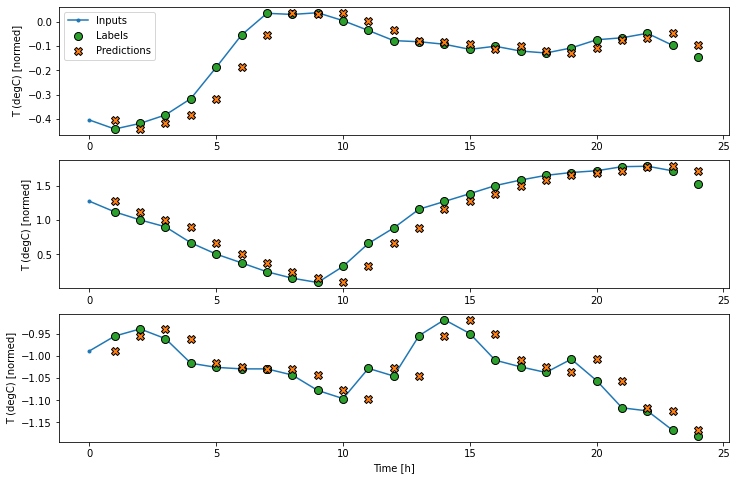

In [107]:
wide_window.plot(baseline)
# 즉 window 를 넓게 해서 plot 을 하겠다는것 입니다. wide 인 경우 label이 길어서 긴 값을 나오게 하거든요
# wide_window 는 window generator 의 객체여서 train , test 등이 다 저장되있거든요! 그래서 그냥 baseline 만 해주면
# 싹다 원하는값이 나온답니다.

위의 세 가지 예에서 단일 단계 모델은 24 시간 동안 실행됩니다. 이것은 약간의 설명이 필요합니다.

- 파란색 "입력"라인은 각 시간 단계에서의 입력 온도를 나타냅니다. 모델은 모든 피쳐를 수신하며이 플롯에는 온도 만 표시됩니다.
- 녹색 "라벨"도트는 목표 예측 값을 나타냅니다. 이 점들은 입력 시간이 아니라 예측 시간에 표시됩니다. 그렇기 때문에 라벨 범위가 입력에 대해 1 단계 씩 이동합니다.
- 주황색 "예측"교차는 각 출력 시간 단계에 대한 모델의 예측입니다. 모델이 완벽하게 예측하는 경우 예측은 "라벨"에 직접 도달합니다.


## Linear model

이 작업에 적용 할 수있는 가장 간단한 훈련 가능한 모델은 입력과 출력 사이에 선형 변환을 삽입하는 것입니다. 이 경우 시간 단계의 출력은 해당 단계에만 의존합니다.

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

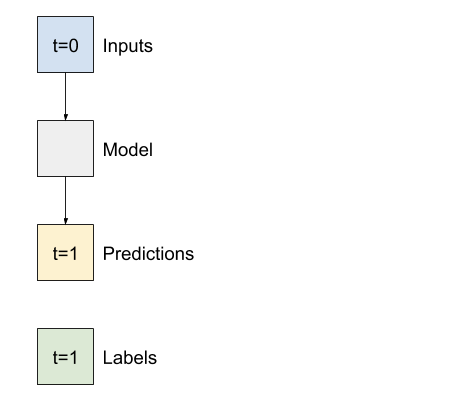

In [108]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries3.PNG') 

In [109]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)]) # 히든노드 하나~ 만 추가!

In [110]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [84]:
MAX_EPOCHS = 20

# 이는 앞으로 우리 모델에서 사용하게될 동일한 기준 / early stopping 이므로 함수로 정의하였습니다.

def compile_and_fit(model, window, patience=2): 
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience, # 2번만 참는대요.. 
                                                    mode='min') 

    model.compile(loss=tf.losses.MeanSquaredError(),   # mse 사용
                optimizer=tf.optimizers.Adam(),  # adam 
                metrics=[tf.metrics.MeanAbsoluteError()]) # mae 사용

    history = model.fit(window.train, 
                        # window 에서 train 객체. 이미 배치가 나뉘어져있고, train/target 도 각각 존재해서 이거 하나면 충분
                      epochs=MAX_EPOCHS,
                        # epoch 는 위에서 정한값
                      validation_data=window.val,
                        # 이 val 의 data 도 위와 같다.
                      callbacks=[early_stopping])
                        # collback 은 위에서 정한거 사용
    return history

In [85]:
single_step_window = WindowGenerator(
    input_width=1, # 위 모델에서 보는거 같이 input 은 1개이므로 1!
    label_width=1, # 예측하게 되는 일수는 하루이므로 1
    shift=1, # 오늘 -> 내일 예측이므로 shift 는 1 입니다.
    label_columns=['T (degC)']) # 어떤 label 을 예측할지
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

Train the model and evaluate its performance:

In [86]:
history = compile_and_fit(linear, single_step_window) # 들어가는건 모델과 / 나눈 window 입니다~

# 아래 과정은 그냥 val 데이터에 대해 performance 를 계산한 것을 평가한것입니다.
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.1062 - mean_absolute_error: 0.1986 - val_loss: 0.0136 - val_mean_absolute_error: 0.0854
Epoch 2/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0120 - mean_absolute_error: 0.0807 - val_loss: 0.0105 - val_mean_absolute_error: 0.0753
Epoch 3/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0103 - mean_absolute_error: 0.0747 - val_loss: 0.0094 - val_mean_absolute_error: 0.0716
Epoch 4/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0095 - mean_absolute_error: 0.0715 - val_loss: 0.0091 - val_mean_absolute_error: 0.0705
Epoch 5/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0703 - val_loss: 0.0087 - val_mean_absolute_error: 0.0683
Epoch 6/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0090 - val_mean_absolute_error: 0.0704
Epoc

baseline 모델과 마찬가지로 선형 모델은 넓은 창 배치에서 호출 할 수 있습니다. 이 방법으로 모델은 연속적인 시간 단계에 대한 독립적 인 예측 세트를 만듭니다. time 축은 다른 batch 축처럼 작동합니다. 각 시간 단계에서 예측간에 상호 작용이 없습니다.

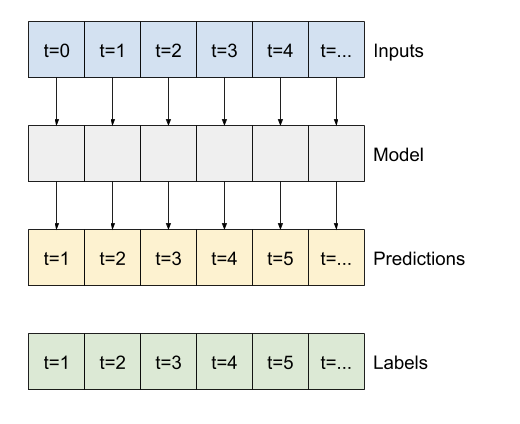

In [87]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries7.PNG') 

In [88]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_widow`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

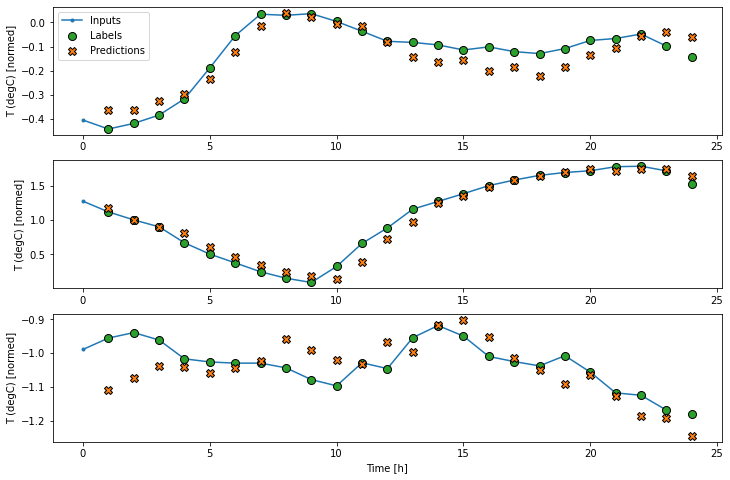

In [89]:
# linear model 에 대해서 window 를 넓게 했을때의 경우는 어떤 그래프가 나올까?
# 즉 별건 아니고 넓게 보자는거에요~ 
# wide_window 는 label_indices 를 24로 했으니까, 이 경우는 24개 예측해줍니다.
# wide
wide_window.plot(linear)

선형 모델의 장점 중 하나는 해석하기가 비교적 쉽다는 것입니다. 레이어의 가중치를 빼내고 각 입력에 지정된 가중치를 볼 수 있습니다.

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights, and see the weight assigned to each input:

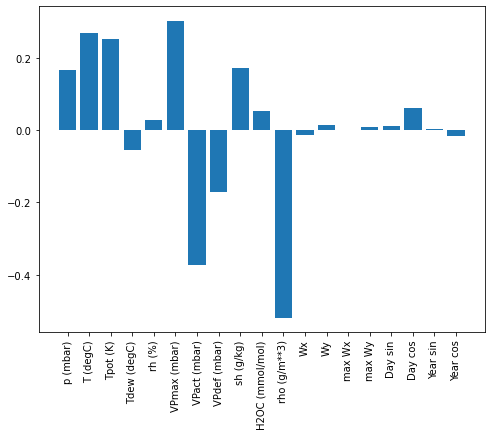

In [90]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

때로는 모델이 입력 T (degC) 에 최대 무게를 두지 않습니다. 이것은 무작위 초기화의 위험 중 하나입니다.

## Dense

실제로 여러 시간 단계에서 작동하는 모델을 적용하기 전에 더 깊고 강력한 단일 입력 단계 모델의 성능을 확인하는 것이 좋습니다.

다음은 linear 모델과 비슷한 모델입니다. 입력과 출력 사이에 몇 개의 Dense 레이어가 쌓여 있다는 점이 다릅니다.

In [91]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)

performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0145 - mean_absolute_error: 0.0789 - val_loss: 0.0082 - val_mean_absolute_error: 0.0664
Epoch 2/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0079 - mean_absolute_error: 0.0644 - val_loss: 0.0077 - val_mean_absolute_error: 0.0633
Epoch 3/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0620 - val_loss: 0.0070 - val_mean_absolute_error: 0.0599
Epoch 4/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0613 - val_loss: 0.0068 - val_mean_absolute_error: 0.0586
Epoch 5/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0598 - val_loss: 0.0069 - val_mean_absolute_error: 0.0595
Epoch 6/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0593 - val_loss: 0.0065 - val_mean_absolute_error: 0.0567
Epoc

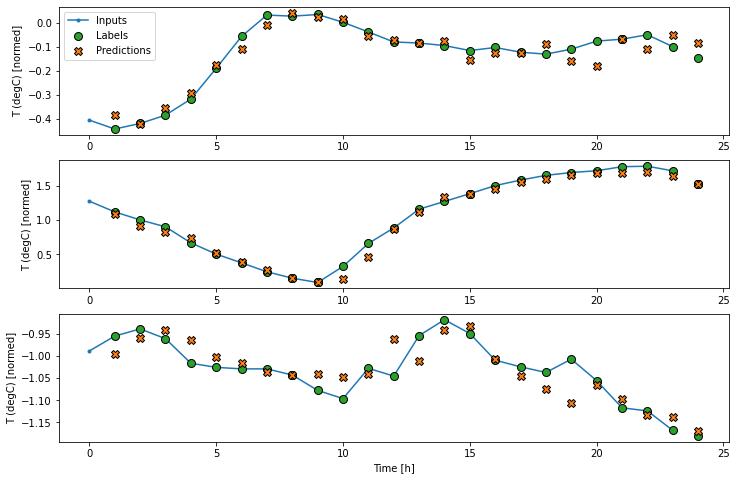

In [95]:
wide_window.plot(dense) # 썩 괜찮네!?

## Multi-step dense

단일 시간 단계 모델에는 현재 입력 값에 대한 컨텍스트가 없습니다. 입력 기능이 시간이 지남에 따라 어떻게 변하는 지 볼 수 없습니다. 이 문제를 해결하려면 예측할 때 모델이 여러 시간 단계에 액세스해야합니다. <br>
즉 아래 그림처럼! 3개 시간을 묶어서 보면 시간에 대한 corr 을 고려하면서 더 예측을 잘 하겟죠오? <br>

baseline , linear 및 dense 모델은 각 단계마다 독립적으로 처리됩니다. 여기서 모델은 단일 출력을 생성하기 위해 입력으로 여러 시간 단계를 수행합니다.

3h의 입력과 1h의 레이블을 일괄 적으로 생성하는 WindowGenerator 를 만듭니다.

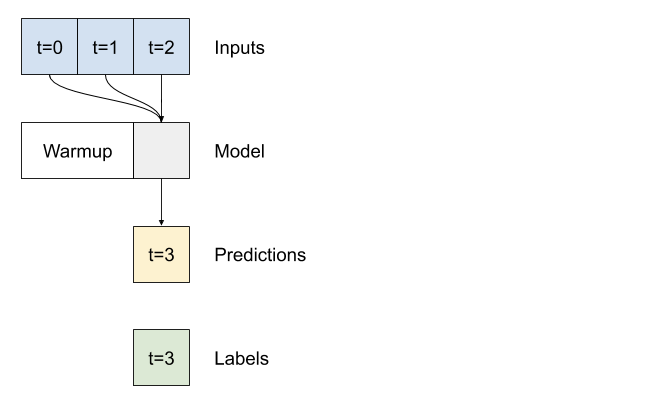

In [97]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries8.PNG') 

In [115]:
CONV_WIDTH = 3 # input 이 이제부터는 3 개 이니까요~
conv_window = WindowGenerator(
    input_width=CONV_WIDTH, 
    label_width=1, # 여전히 예측은 바로 그 뒤값입니다.
    shift=1, # 음.. 1 기간 뒤에거 예측
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Given 3h as input, predict 1h into the future. 를 하는 그림입니다.

아직 모델은 없어서 predict 값은 없구 그냥 label 만 있는 모습이에요

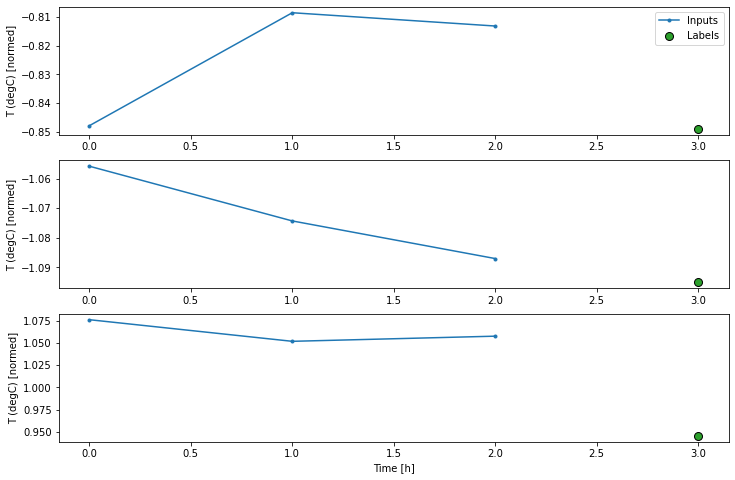

In [116]:
conv_window.plot()

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

In [117]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(), 
    # 원래 NN 으로 들어가려면 어떻게? 바로 flatten 과정이 있어야 한댔죠!
    # 현재 모델은 시간이 3 들어갔기 떄문에 shape 가 (3, feature) 의 형태이기 떄문입니다~
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension. (output 은 time 을 고려할 수 있게 1 이 붙어주는게 좋아요)
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [118]:
# 과연 example 에 대해서 conv_window 는 모델을 거치면서 어떤 모양으로 변화할까요~?
print('Input shape:', conv_window.example[0].shape) 
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [119]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 0s 801us/step - loss: 0.0062 - mean_absolute_error: 0.0539


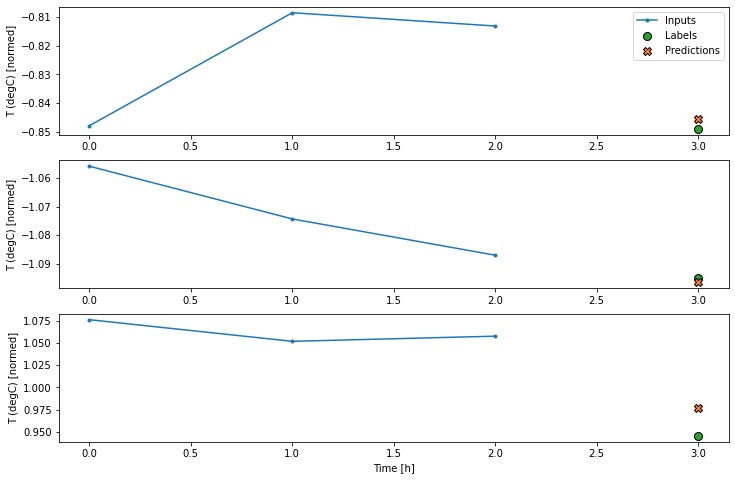

In [122]:
conv_window.plot(multi_step_dense)

이 방법의 주요 단점은 결과 모델을 정확히이 모양의 입력 창에서만 실행할 수 있다는 것입니다.... ㅜㅜ

In [126]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')
# 에러가 뜨죠...

Input shape: (32, 24, 19)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,456], In[1]: [57,32] [Op:MatMul]


The convolutional models in the next section fix this problem.

## Convolution neural network


Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

컨벌루션 레이어 ( layers.Conv1D )는 각 예측에 대한 입력으로 여러 시간 단계를 사용합니다.

다음은 컨볼 루션으로 다시 작성된 multi_step_dense 와 동일한 모델입니다.
변경 사항을 참고하십시오.

- layers.Flatten 상기 제 layers.Dense a로 대체 layers.Conv1D .
- 컨볼 루션이 시간 축을 출력에 유지하므로 layers.Reshape 를 더 이상 layers.Reshape 할 필요가 없습니다.


In [129]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,), # 시간에 대해 3 을 사용!
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to see that the model produces outputs with the expected shape:

In [130]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [131]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 0s 898us/step - loss: 0.0078 - mean_absolute_error: 0.0637


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](https://github.com/hana-dool/Data_Analysis/blob/master/images/wide_conv_window.png?raw=1)

If you run it on wider input, it produces wider output:

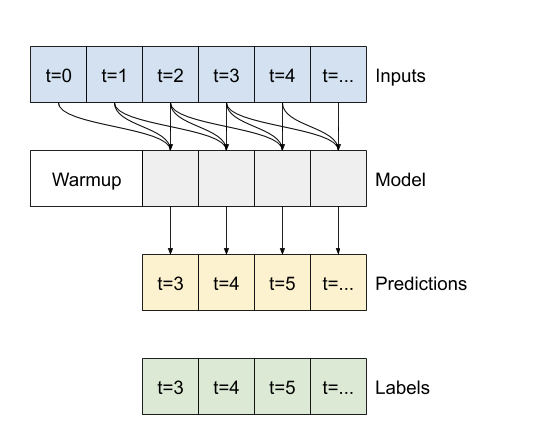

In [81]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries9.PNG') 

더 넓은 입력에서 실행하면 더 넓은 출력이 생성됩니다.

In [132]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


출력은 입력보다 짧습니다. 훈련 또는 플로팅 작업을 수행하려면 레이블과 예측의 길이가 같아야합니다. 따라서 레이블과 예측 길이가 일치하도록 몇 가지 추가 입력 시간 단계를 사용하여 넓은 창을 생성하는 WindowGenerator 를 빌드하십시오.

In [133]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1) # 길이를 같게하려구요~
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [134]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding timesteps:

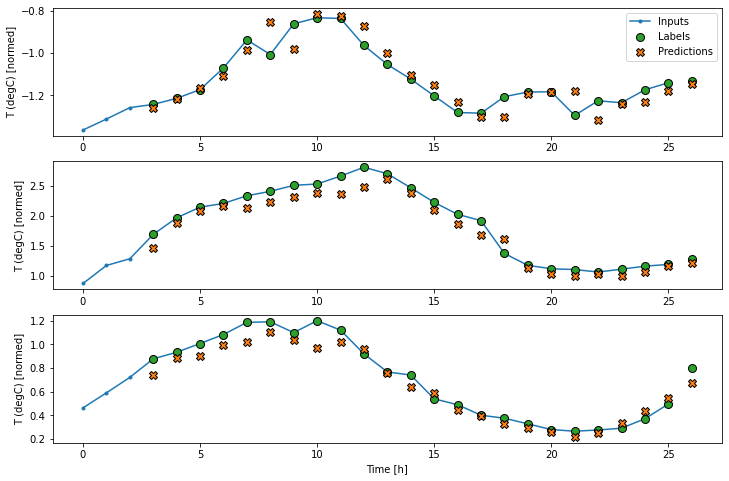

In [135]:
wide_conv_window.plot(conv_model)

## Recurrent neural network

RNN (Recurrent Neural Network)은 시계열 데이터에 적합한 신경 네트워크 유형입니다. RNN은 시계열을 단계별로 처리하여 단계별로 내부 상태를 유지합니다.

자세한 내용은 텍스트 생성 자습서 또는 RNN 안내서를 참조하십시오 .

이 학습서에서는 LSTM (Long Short Term Memory)이라는 RNN 계층을 사용합니다.

모든 keras RNN 계층에 중요한 생성자 인수는 return_sequences 인수입니다. 이 설정은 두 가지 방법 중 하나로 계층을 구성 할 수 있습니다.



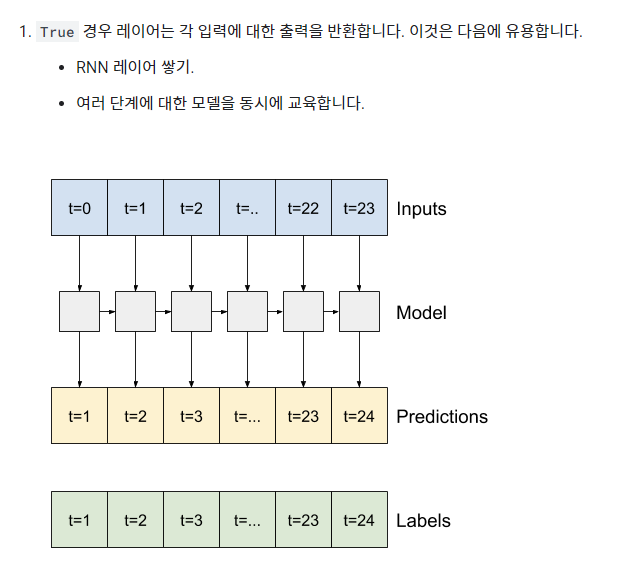

In [136]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries11.PNG') 

In [140]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True), 
    # hidden state 의 dim 이 맨 앞 unit 이다. (문서 참조)
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1) # 맨 마지막의 출력층. 
])

With `return_sequences=True` the model can be trained on 24h of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first timestep the model has no access to previous steps, and so can't do any better than the simple `linear` and `dense` models shown earlier.

In [141]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [142]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 2ms/step - loss: 0.0055 - mean_absolute_error: 0.0512


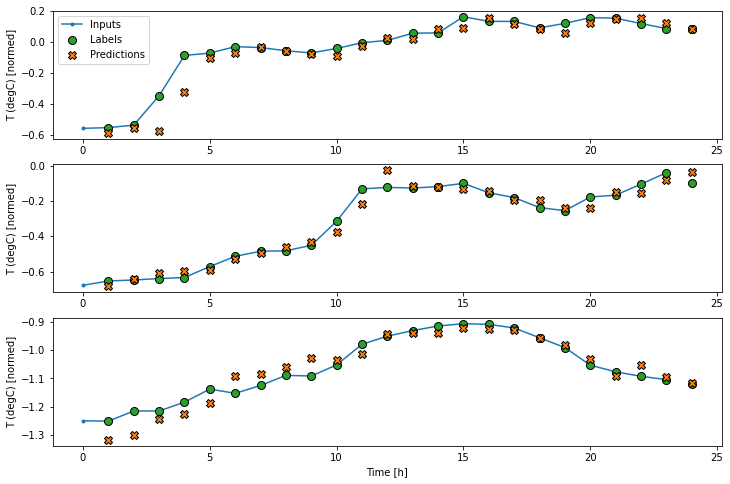

In [95]:
wide_window.plot(lstm_model)

## Performance

With this dataset typically each of the models does slightly better than the one before it.

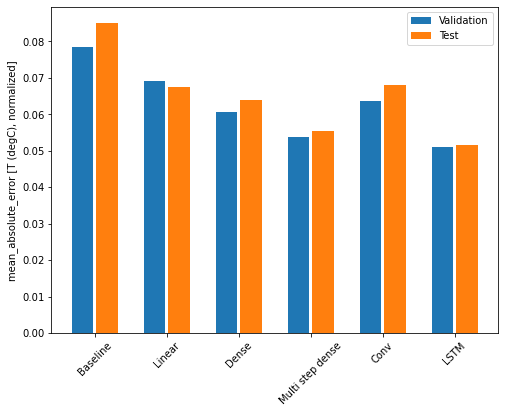

In [143]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [144]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0675
Dense       : 0.0639
Multi step dense: 0.0555
Conv        : 0.0680
LSTM        : 0.0517


# Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.



In [98]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of 1.

## Baseline

The same baseline model can be used here, but this time repeating all features instead of selecting a specific `label_index`.

In [99]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [100]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 0s 1ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


## Dense

In [101]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [102]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 0s 1ms/step - loss: 0.0684 - mean_absolute_error: 0.1294


## RNN



In [103]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 1s 2ms/step - loss: 0.0616 - mean_absolute_error: 0.1201

Wall time: 1min 55s


<a id="residual"></a>

## Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict the how the value will change in the next timestep.
Similarly, "Residual networks" or "ResNets" in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](https://github.com/hana-dool/Data_Analysis/blob/master/images/residual.png?raw=1)

Essentially this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

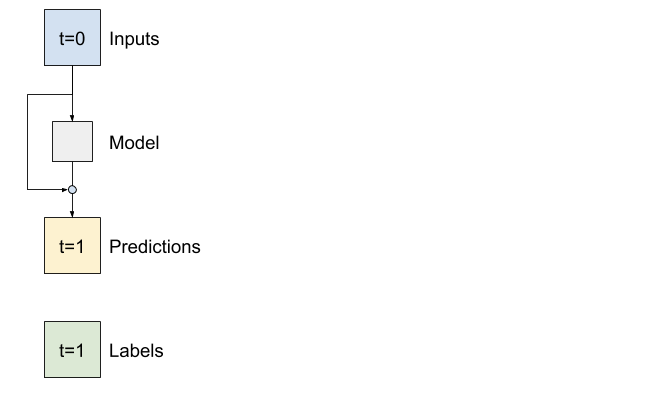

In [104]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries12.PNG') 

In [105]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [106]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

438/438 [==============================] - 1s 2ms/step - loss: 0.0620 - mean_absolute_error: 0.1178

Wall time: 1min 12s


## Performance

Here is the overall performance for these multi-output models.

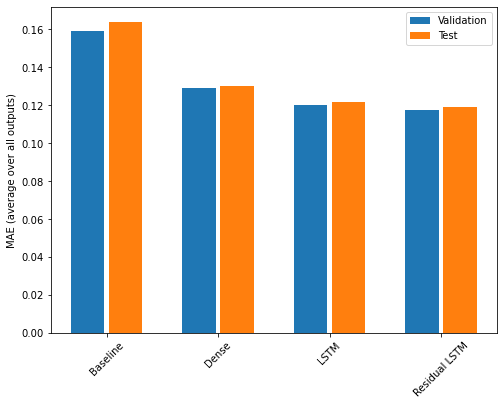

In [107]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [108]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1301
LSTM           : 0.1215
Residual LSTM  : 0.1192


The above performances are averaged across all model outputs.

# Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, 1h into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.



이전 섹션의 단일 출력 및 다중 출력 모델 모두 단일 시간 단계 예측 을 1h로 만들었습니다.

이 섹션에서는 이러한 모델을 확장하여 여러 시간 단계 예측을 수행 하는 방법을 살펴 봅니다.

다단계 예측에서 모델은 미래의 값 범위를 예측하는 법을 배워야합니다. 따라서 단일 미래 포인트 만 예측되는 단일 단계 모델과 달리 다단계 모델은 미래 값의 시퀀스를 예측합니다.

이에 대한 두 가지 대략적인 접근 방식이 있습니다.

1. 전체 시계열이 한 번에 예측되는 단일 샷 예측.
2. 모델이 단일 단계 예측 만 수행하고 출력이 입력으로 피드백되는 자동 회귀 예측.

이 섹션에서 모든 모델은 모든 출력 시간 단계에서 모든 기능을 예측 합니다 .

다단계 모델의 경우 훈련 데이터는 다시 시간별 샘플로 구성됩니다. 그러나 여기서 모델은 과거 24 시간을 고려하여 미래 24 시간을 예측하는 방법을 학습합니다.

다음은 데이터 세트에서 이러한 슬라이스를 생성하는 Window 객체입니다

For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

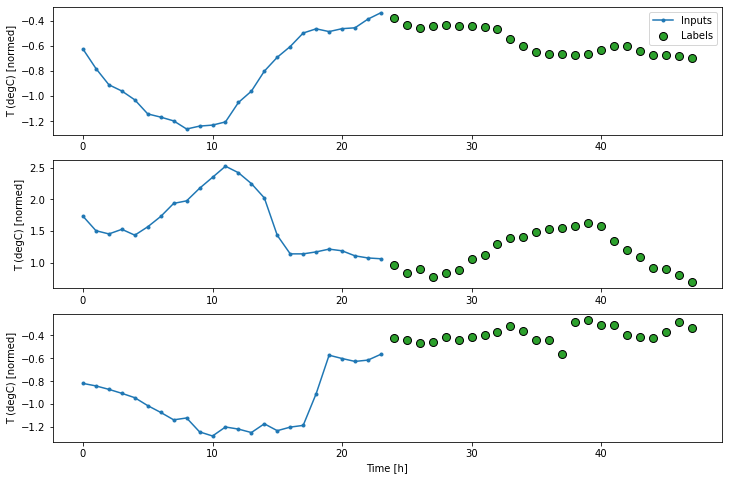

In [145]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS, # 저는 24개를 예측하고싶어요!
                               shift=OUT_STEPS) # shift 는 24겟죠? 

multi_window.plot()
multi_window

## Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps

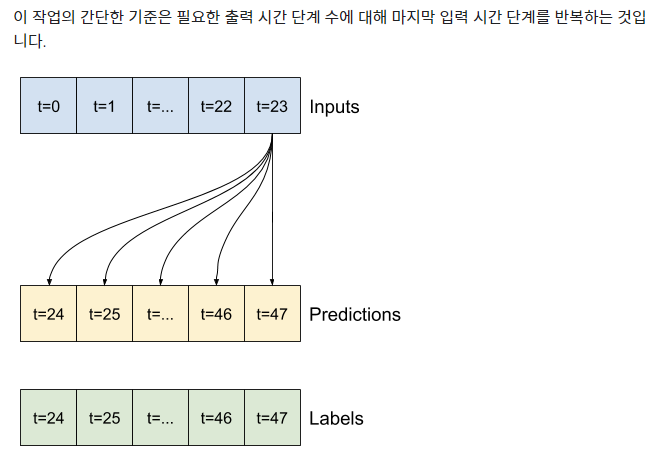

In [147]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries13.PNG') 

437/437 [==============================] - 1s 1ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


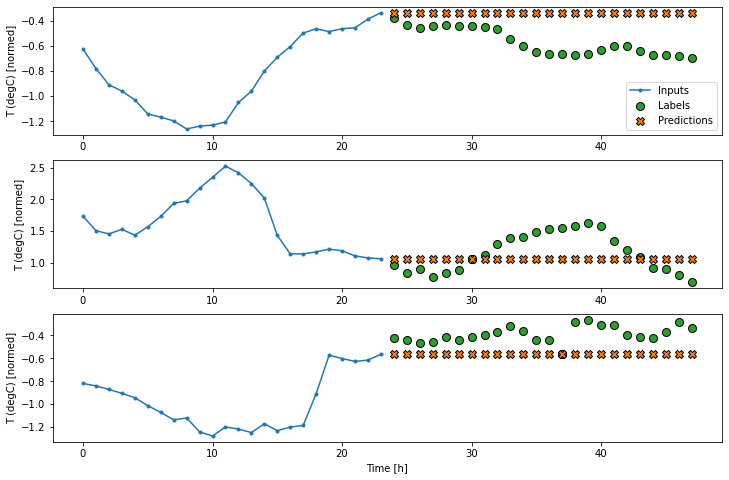

In [148]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24h given 24h another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](https://github.com/hana-dool/Data_Analysis/blob/master/images/multistep_repeat.png?raw=1)

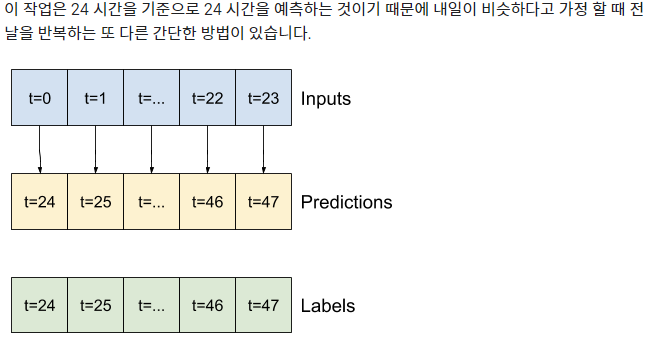

In [149]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries14.PNG') 

437/437 [==============================] - 1s 1ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


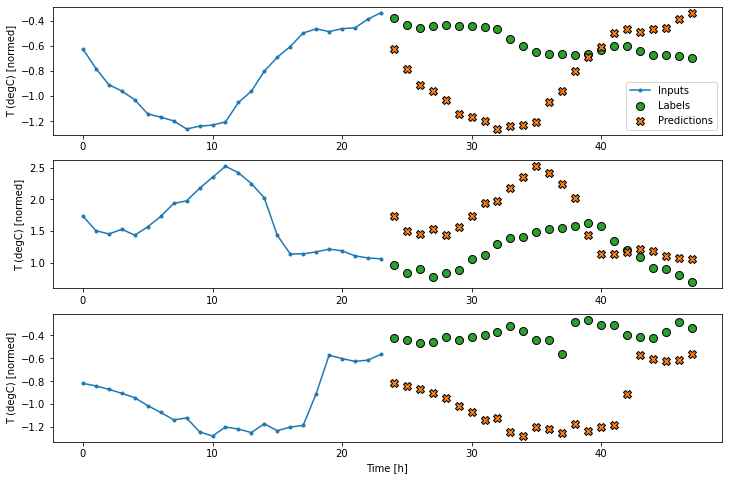

In [150]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## Single-shot models

One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predct all timesteps from the last time-step](https://github.com/hana-dool/Data_Analysis/blob/master/images/multistep_dense.png?raw=1)

이 문제에 대한 한 가지 높은 수준의 접근 방식은 "단일 샷"모델을 사용하는 것입니다. 여기서 모델은 전체 시퀀스 예측을 단일 단계로 수행합니다.

OUT_STEPS*features 의 layers.Dense 로 출력 단위를 OUT_STEPS*features 합니다. 모델은 해당 출력을 필수 (OUTPUT_STEPS, features) 됩니다.

선의
마지막 입력 시간 단계를 기반으로하는 간단한 선형 모델은 어느 기준선보다 우수하지만 전력이 부족합니다. 모델은 선형 투영을 사용하는 단일 입력 시간 단계에서 OUTPUT_STEPS 시간 단계를 예측해야합니다. 주로 시간과 연도를 기준으로 저 차원의 동작 조각 만 캡처 할 수 있습니다.



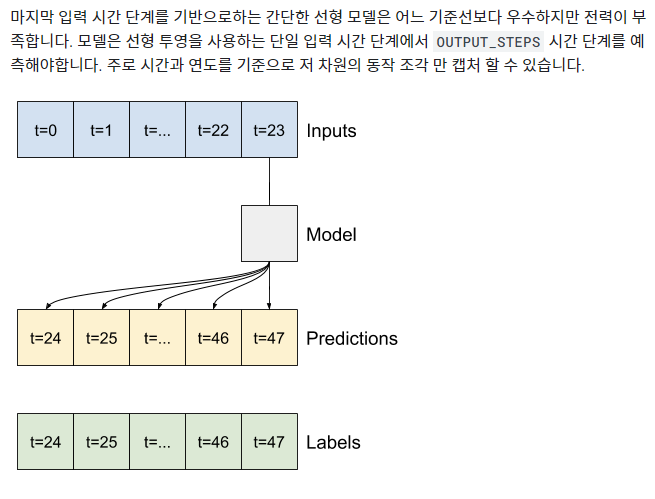

In [151]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries15.PNG') 

437/437 [==============================] - 1s 1ms/step - loss: 0.2557 - mean_absolute_error: 0.3050


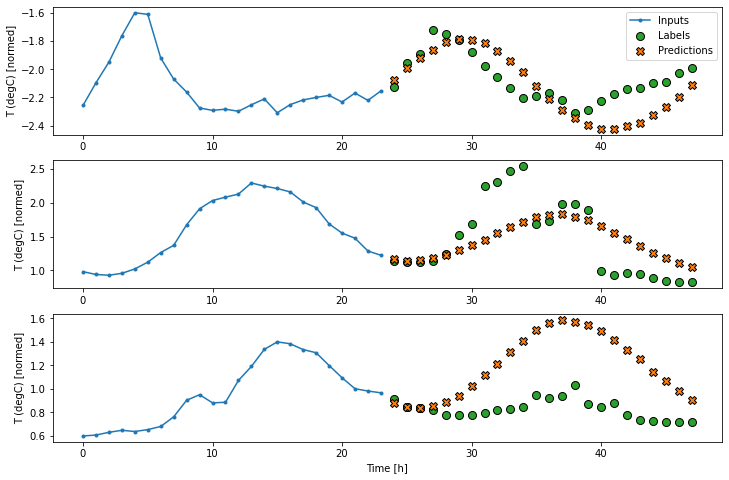

In [116]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features, # out steps 는 24 입니다.
                          kernel_initializer=tf.initializers.zeros), # dense 층을 통해 nn 
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features]) # 다시 reshape
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

### Dense

layers.Dense 추가 입력과 출력 사이의 layers.Dense 는 선형 모델에 더 많은 전력을 제공하지만 여전히 단일 입력 시간 단계에만 기반합니다.

437/437 [==============================] - 0s 1ms/step - loss: 0.2203 - mean_absolute_error: 0.2828


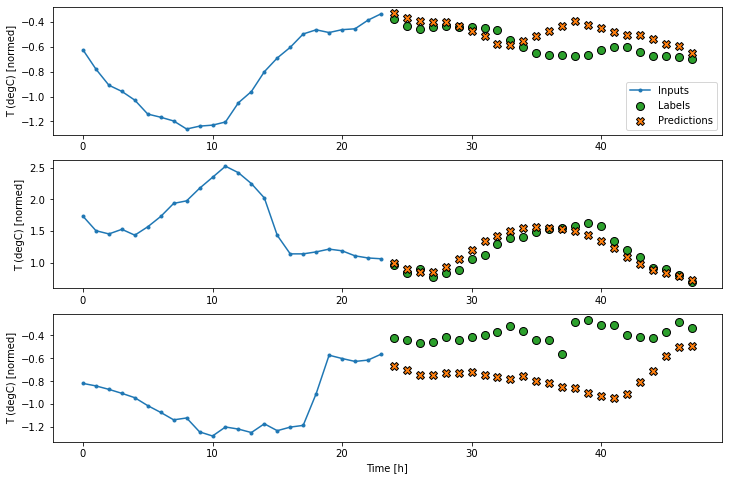

In [152]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'), # 층 하나~
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros), #나머지 하나 더!
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

## CNN

컨벌루션 모델은 고정 너비 히스토리를 기반으로 예측을 수행하므로 시간이 지남에 따라 상황이 어떻게 변하는 지 볼 수 있으므로 밀도 모델보다 성능이 향상 될 수 있습니다.

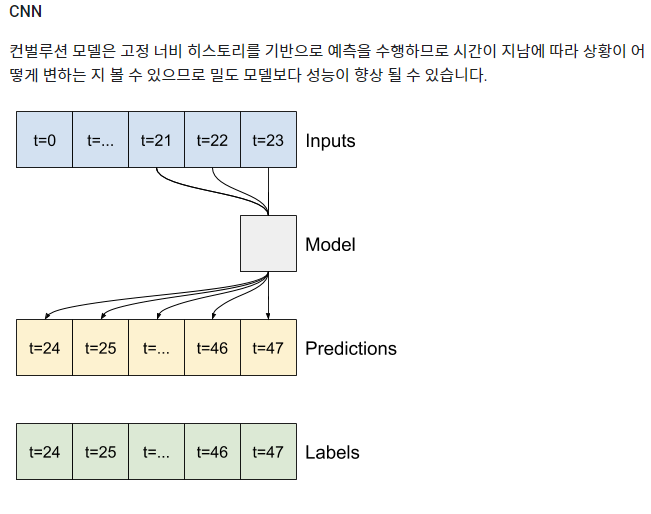

In [153]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries16.PNG') 

437/437 [==============================] - 0s 1ms/step - loss: 0.2168 - mean_absolute_error: 0.2831


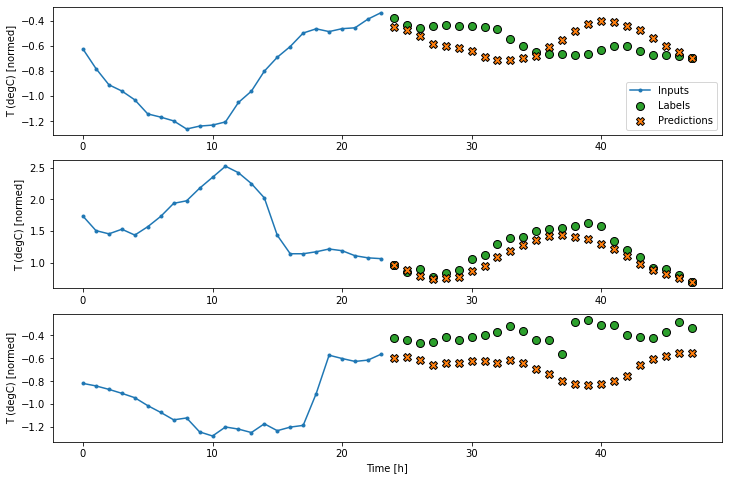

In [154]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

## RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](https://github.com/hana-dool/Data_Analysis/blob/master/images/multistep_lstm.png?raw=1)


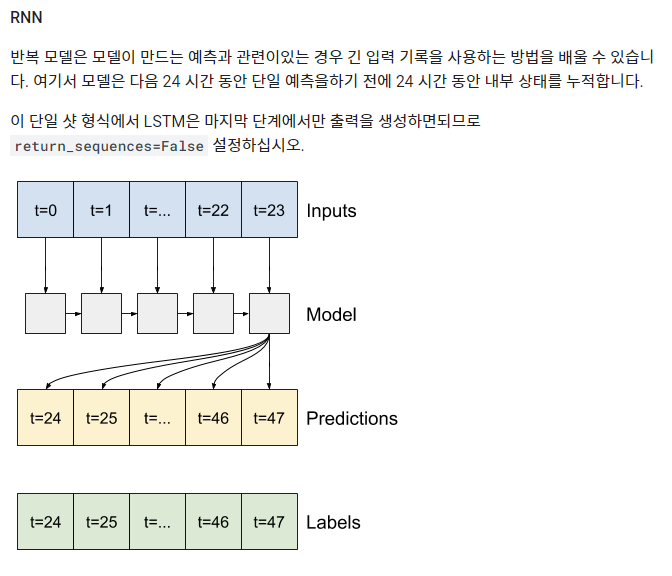

In [155]:
Image('C:/Users/goran/Desktop/Git_hub/Data_Analasys/Pictures/Timeseries17.PNG') 

437/437 [==============================] - 1s 2ms/step - loss: 0.2135 - mean_absolute_error: 0.2857


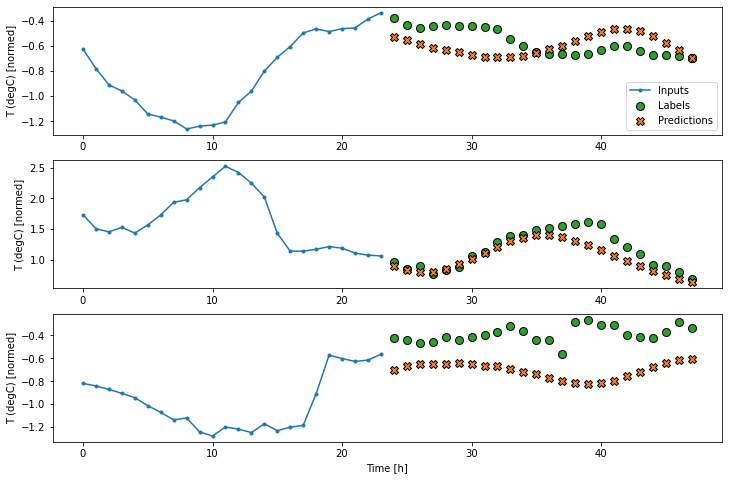

In [156]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train, verbose=0)
multi_window.plot(multi_lstm_model)

In [158]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5007
Repeat  : 0.3774
Dense   : 0.2760
Conv    : 0.2750
LSTM    : 0.2735
